<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C2/W2/ungraded_labs/C2_W2_Lab_2_horses_v_humans_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Data Augmentation on the Horses or Humans Dataset

In the previous lab, you saw how data augmentation helped improve the model's performance on unseen data. By tweaking the cat and dog training images, the model was able to learn features that are also representative of the validation data. However, applying data augmentation requires good understanding of your dataset. Simply transforming it randomly will not always yield good results. 

In the next cells, you will apply the same techniques to the `Horses or Humans` dataset and analyze the results.

In [ ]:
# Install this package to use Colab's GPU for training
# !apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

In [1]:
# Download the training set
!wget -P data_C2W2/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

--2022-10-03 21:40:44--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.62.128, 142.251.33.208, 172.217.0.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.62.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘data_C2W2/horse-or-human.zip’

horse-or-human.zip  100%[===================>] 142.65M  3.04MB/s    in 35s     

2022-10-03 21:41:19 (4.13 MB/s) - ‘data_C2W2/horse-or-human.zip’ saved [149574867/149574867]



In [2]:
# Download the validation set
!wget -P data_C2W2/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

--2022-10-03 21:41:40--  https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.1.208, 142.251.33.208, 172.217.0.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.1.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘data_C2W2/validation-horse-or-human.zip’

validation-horse-or 100%[===================>]  10.95M  3.80MB/s    in 2.9s    

2022-10-03 21:41:43 (3.80 MB/s) - ‘data_C2W2/validation-horse-or-human.zip’ saved [11480187/11480187]



In [3]:
import os
import zipfile

# Extract the archive
zip_ref = zipfile.ZipFile("./data_C2W2/horse-or-human.zip", "r")
zip_ref.extractall("data_C2W2/tmp/horse-or-human")

zip_ref = zipfile.ZipFile("./data_C2W2/validation-horse-or-human.zip", "r")
zip_ref.extractall("data_C2W2/tmp/validation-horse-or-human")

zip_ref.close()

# Directory with training horse pictures
train_horse_dir = os.path.join("data_C2W2/tmp/horse-or-human/horses")

# Directory with training human pictures
train_human_dir = os.path.join("data_C2W2/tmp/horse-or-human/humans")

# Directory with training horse pictures
validation_horse_dir = os.path.join("data_C2W2/tmp/validation-horse-or-human/horses")

# Directory with training human pictures
validation_human_dir = os.path.join("data_C2W2/tmp/validation-horse-or-human/humans")

In [7]:
import tensorflow as tf

# Build the model
model = tf.keras.models.Sequential(
    [
        # Note the input shape is the desired size of the image 300x300 with 3 bytes color
        # This is the first convolution
        tf.keras.layers.Conv2D(
            16, (3, 3), activation="relu", input_shape=(300, 300, 3)
        ),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The third convolution
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The fourth convolution
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The fifth convolution
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(2, 2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation="relu"),
        # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

Metal device set to: Apple M1


2022-10-03 21:44:41.689394: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-03 21:44:41.689947: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
from tensorflow.keras.optimizers import RMSprop

# Set training parameters
model.compile(
    loss="binary_crossentropy",
    optimizer=RMSprop(learning_rate=1e-4),
    metrics=["accuracy"],
)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Apply data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

validation_datagen = ImageDataGenerator(rescale=1 / 255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    "data_C2W2/tmp/horse-or-human/",  # This is the source directory for training images
    target_size=(300, 300),  # All images will be resized to 150x150
    batch_size=128,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode="binary",
)

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    "data_C2W2/tmp/validation-horse-or-human/",  # This is the source directory for training images
    target_size=(300, 300),  # All images will be resized to 150x150
    batch_size=32,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode="binary",
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [10]:
# Constant for epochs
EPOCHS = 20

# Train the model
history = model.fit(
    train_generator,
    # steps_per_epoch=8,
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_generator,
    # validation_steps=8,
)

Epoch 1/20


2022-10-03 21:45:53.947185: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-03 21:45:54.237278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.5735

2022-10-03 21:46:09.828926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - 17s 2s/step - loss: 0.6790 - accuracy: 0.5735 - val_loss: 0.6444 - val_accuracy: 0.8906
Epoch 2/20
9/9 [==============================] - 14s 2s/step - loss: 0.6861 - accuracy: 0.6134 - val_loss: 0.6329 - val_accuracy: 0.6367
Epoch 3/20
9/9 [==============================] - 16s 2s/step - loss: 0.6318 - accuracy: 0.6758 - val_loss: 0.6253 - val_accuracy: 0.5469
Epoch 4/20
9/9 [==============================] - 17s 2s/step - loss: 0.6244 - accuracy: 0.6689 - val_loss: 0.6245 - val_accuracy: 0.5586
Epoch 5/20
9/9 [==============================] - 18s 2s/step - loss: 0.5932 - accuracy: 0.6641 - val_loss: 0.5943 - val_accuracy: 0.5898
Epoch 6/20
9/9 [==============================] - 16s 2s/step - loss: 0.5500 - accuracy: 0.7390 - val_loss: 0.6746 - val_accuracy: 0.5352
Epoch 7/20
9/9 [==============================] - 16s 2s/step - loss: 0.5384 - accuracy: 0.7196 - val_loss: 0.7906 - val_accuracy: 0.5312
Epoch 8/20
9/9 [=============================

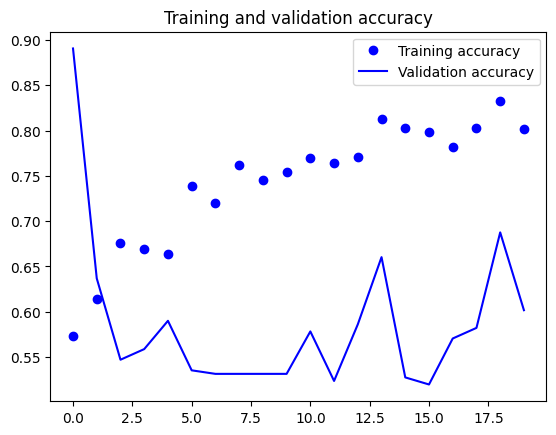

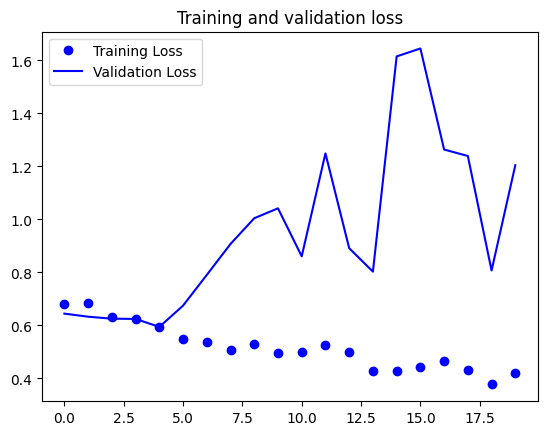

In [12]:
import matplotlib.pyplot as plt

# Plot the model results
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

As you can see in the results, the preprocessing techniques used in augmenting the data did not help much in the results. The validation accuracy is fluctuating and not trending up like the training accuracy. This might be because the additional training data generated still do not represent the features in the validation data. For example, some human or horse poses in the validation set cannot be mimicked by the image processing techniques that `ImageDataGenerator` provides. It might also be that the background of the training images are also learned so the white background of the validation set is throwing the model off even with cropping. Try looking at the validation images in the `tmp/validation-horse-or-human` directory (note: if you are using Colab, you can use the file explorer on the left to explore the images) and see if you can augment the training images to match its characteristics. If this is not possible, then at this point you can consider other techniques and you will see that in next week's lessons.